In [1]:
import logging
import os.path
import numpy as np
import matplotlib.pyplot as plt

import theano_shim as shim
import sinn
from sinn.histories import Spiketrain, Series
import sinn.iotools as io
import sinn.analyze as anlz
import sinn.analyze.heatmap as heatmap
import sinn.optimize.gradient_descent as gd

import main
import fsgif_model as fsgif

import copy


np.set_printoptions(precision=3, suppress=True)
%matplotlib inline

try:
    # Guard against defining multiple loggers
    logger
except NameError:
    rootlogger = logging.getLogger()
    rootlogger.setLevel(sinn.LoggingLevels.MONITOR)

    sthandler = logging.StreamHandler()
    sthandler.setLevel(logging.INFO)
    sthandler.setFormatter(sinn.config.logging_formatter)
    rootlogger.addHandler(sthandler)
    
    filehandler = logging.handlers.RotatingFileHandler(
        'fsgif.log', mode='w', maxBytes=5e5, backupCount=5)
    filehandler.setLevel(sinn.LoggingLevels.MONITOR)
    filehandler.setFormatter(sinn.config.logging_formatter)
    rootlogger.addHandler(filehandler)
    
    logger = logging.getLogger('fsgif')
    logger.setLevel(logging.INFO)

[monochrome_palette]: value was greater than 1 and was clipped.


In [2]:
def plot_L(datalen_lst, filename, desc_str='L', title=""):
    ncols = 2 if len(datalen_lst) > 1 else 1
    nrows = int(np.ceil(len(datalen_lst) / 2))
    plt.figure(figsize=(5*ncols, 4*nrows))

    for i, T in enumerate(datalen_lst):
        plt.subplot(nrows,ncols,i+1)

        #plt.title("Likelihood, {}s data".format(T))
        plt.title(title.format(T))
        #filename = basedir + "fsgif_{}s_sin-input_likelihood_2.sir".format(T)
        logL_base = heatmap.HeatMap.from_raw(io.loadraw( filename.format(T) ))
        params = [None]*2
        for j in range(2):
            params[j] = getattr(spikemodel.params, logL_base.axes[j].name)
            if logL_base.axes[j].idx is not None:
                params[j] = params[j][logL_base.axes[j].idx]
        
        if desc_str == 'L':
            L = main.exploglikelihood(logL_base)
        elif desc_str == 'log L':
            L = logL_base - logL_base.max()
            L.set_ceil(0)
            L.set_floor(-100)
            L.zlabel = 'log $L$'
        else:
            raise ValueError("Unrecognized desc string '{}'".format(desc_str))
        anlz.plot(L)

        color = anlz.stylelib.color_schemes.cmaps[L.cmap].white
        plt.axvline(params[0], c=color)
        plt.axhline(params[1], c=color)

        plt.xlabel('$'+logL_base.axes[0].name+'$')
        plt.ylabel('$'+logL_base.axes[1].name+'$')

    plt.tight_layout()

In [3]:
basedir = os.path.expanduser('~/Recherche/data/mackelab/code/fsGIF/')
basedir = os.path.expanduser('~/Recherche/macke_lab/labnotes/plots/2017-07-05/')

In [4]:
main.load_spikes(basedir + 'fsgif_10s_sin-input.sir')
spikemodel = main.loaded['spiking model']

2017-07-18 14:05:29,251 - root - INFO - Checking for precomputed data...


In [5]:
import sinn.analyze.heatmap as heatmap
logL = heatmap.HeatMap.from_raw(io.loadraw(basedir + "fsgif_2s_sin-input_likelihood_2.sir"))

# Numpy likelihoods

## Original adaptation constant ($τ_a$ = 1 ms)

In [22]:
basedir = os.path.expanduser('~/Recherche/data/mackelab/code/fsGIF/normal_adap/')

In [7]:
filename_base = basedir + "fsgif_{}s_sin-input_likelihood"
for i, T in enumerate([2,4,6,8]):
    filename = filename_base.format(T)
    logL_base = io.load( filename + ".sin")
    io.saveraw( filename + ".sir", logL_base)

### Likelihood

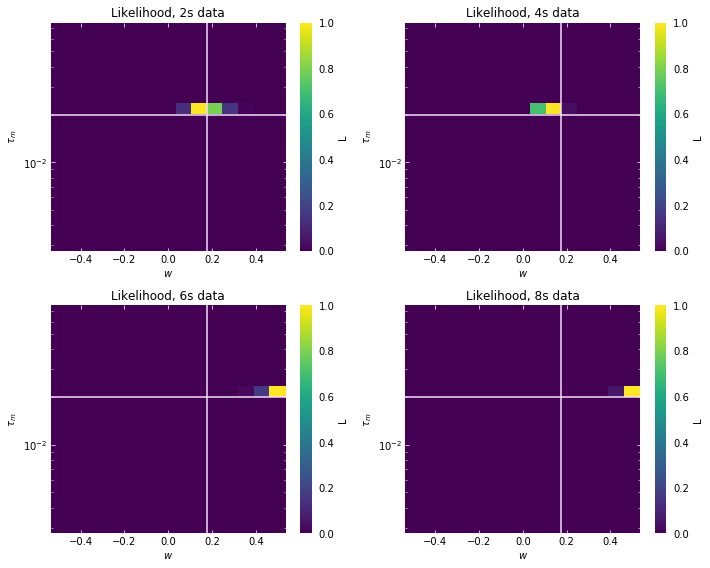

In [8]:
plot_L([2,4,6,8],
       basedir + "fsgif_{}s_sin-input_likelihood.sir",
       'L',
       "Likelihood, {}s data")

### Log likelihood

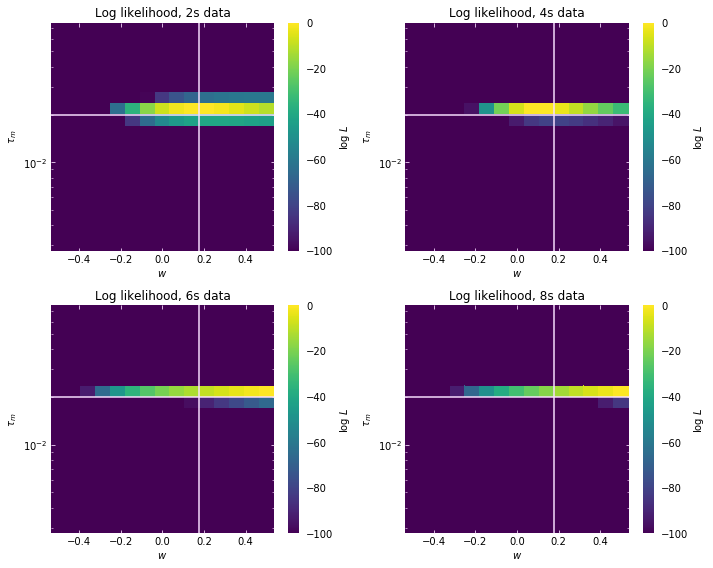

In [23]:
plot_L([2,4,6,8],
       basedir + "fsgif_{}s_sin-input_likelihood.sir",
       'log L',
       "Log likelihood, {}s data")

## Short adaptation constant ($τ_a$ = 0.2 ms)

### Likelihood

In [26]:
basedir = os.path.expanduser('~/Recherche/macke_lab/labnotes/plots/2017-07-05/')

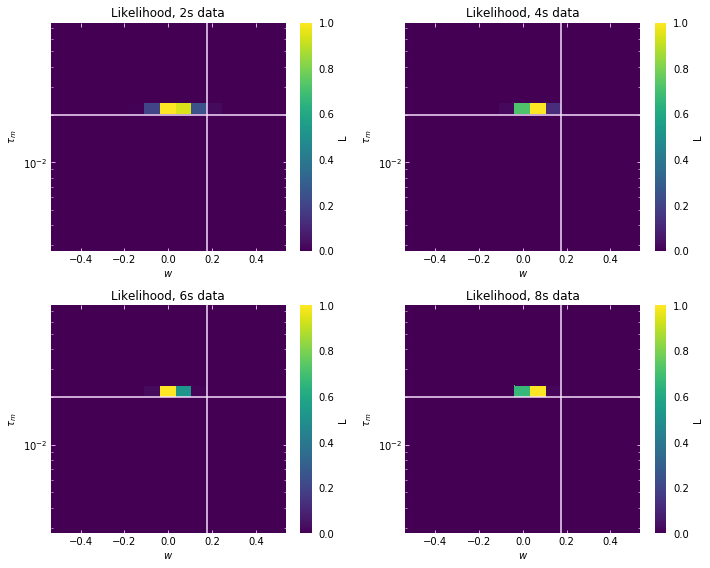

In [27]:
plot_L([2,4,6,8],
       basedir + "fsgif_{}s_sin-input_likelihood_2.sir",
       'L',
       "Likelihood, {}s data")

### Log likelihood

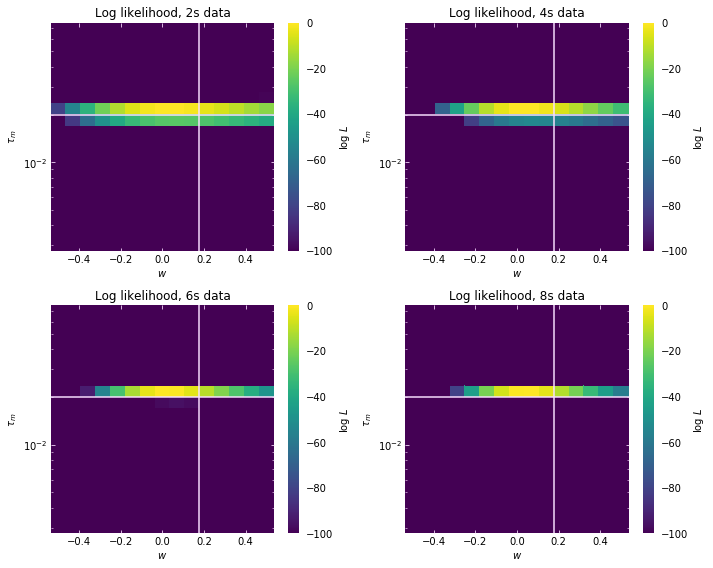

In [25]:
plot_L([2,4,6,8],
       basedir + "fsgif_{}s_sin-input_likelihood_2.sir",
       'log L',
       "Log likelihood, {}s data")

# Theano likelihoods
Calculating the likelihood with Theano is slower than with Numpy, so I limited runs to 2s and 4s data lengths.

## Short adaptation constant ($τ_a$ = 0.2 ms)

In [25]:
basedir = os.path.expanduser('~/Recherche/macke_lab/code/fsGIF/data/short_adap/')

In [7]:
filename_base = basedir + "fsgif_{}s_sin-input_likelihood_theano_2"
for i, T in enumerate([4,6]):
    filename = filename_base.format(T)
    logL_base = io.load( filename + ".sin")
    io.saveraw( filename + ".sir", logL_base)

### Likelihood

(-0.5, 1.5)

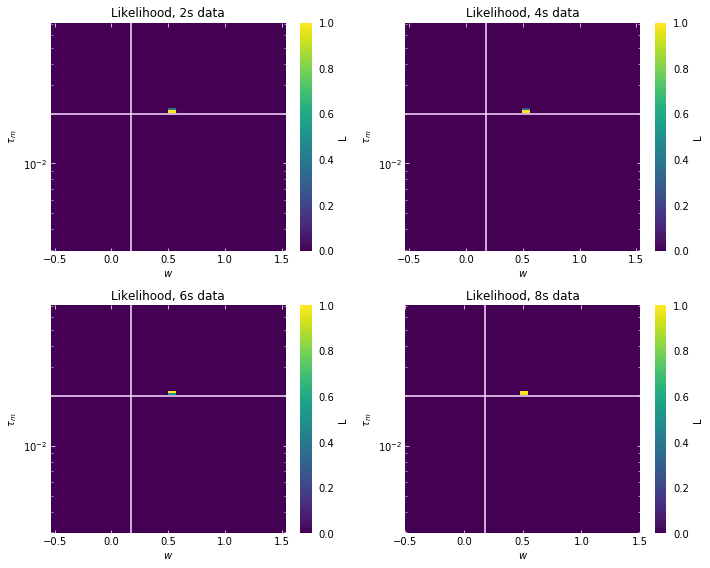

In [10]:
plot_L([2,4,6,8],
       basedir + "fsgif_sin-input_{}s_likelihood_theano.sir",
       'L',
       "Likelihood, {}s data")
plt.xlim((-0.5,1.5))

### Log likelihood

(-0.5, 1.5)

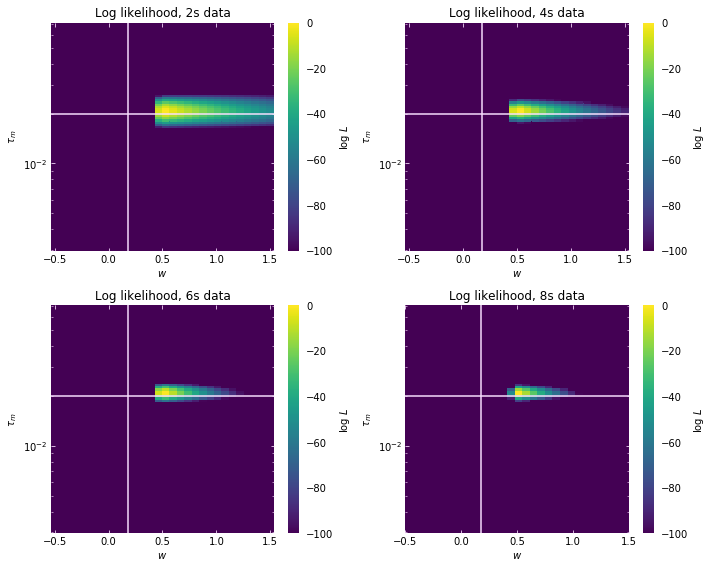

In [13]:
plot_L([2,4,6,8],
       basedir + "fsgif_sin-input_{}s_likelihood_theano.sir",
       'log L',
       "Log likelihood, {}s data")
plt.xlim((-0.5,1.5))

## Without burnin

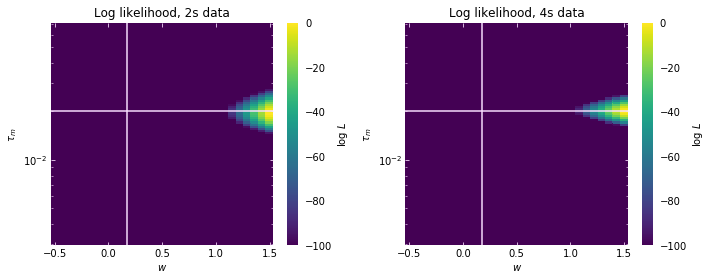

In [30]:
plot_L([2,4],
       basedir + "fsgif_sin-input_{}s_likelihood_noburnin_theano.sir",
       'log L',
       "Log likelihood, {}s data")

## Exploration

In [30]:
logL = heatmap.HeatMap.from_raw(io.loadraw(basedir + "fsgif_4s_sin-input_loglikelihood_numpy_corrected.sir"))

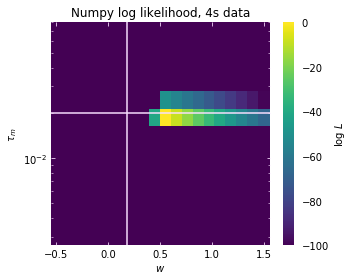

In [42]:
plot_L([4],
      basedir + "fsgif_{}s_sin-input_loglikelihood_numpy_corrected.sir",
      'log L',
      "Numpy log likelihood, {}s data")

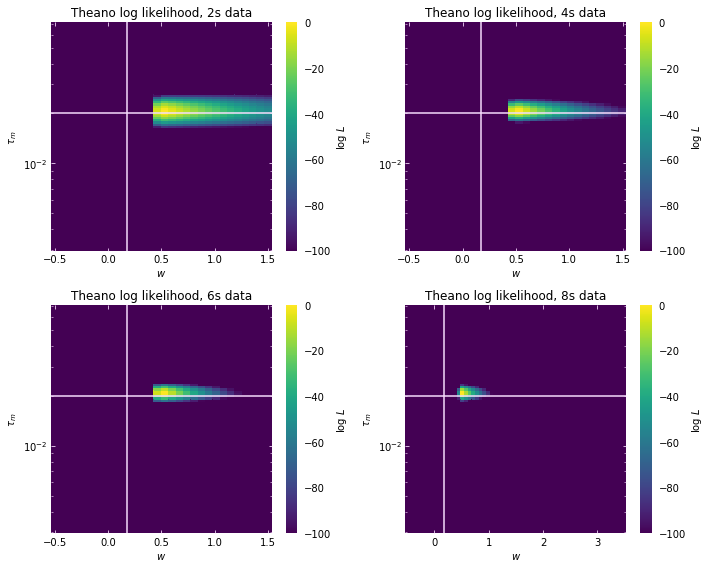

In [44]:
plot_L([2,4,6,8],
      basedir + "fsgif_sin-input_{}s_likelihood_theano.sir",
      'log L',
      "Theano log likelihood, {}s data")

In [26]:
logLT = heatmap.HeatMap.from_raw(io.loadraw(basedir + "fsgif_sin-input_4s_likelihood_theano.sir"))

In [27]:
logLT.set_floor(logLT.max() - 100)

(<matplotlib.axes._subplots.AxesSubplot at 0x7f5464a9a518>,
 <matplotlib.colorbar.Colorbar at 0x7f54610ae2b0>)

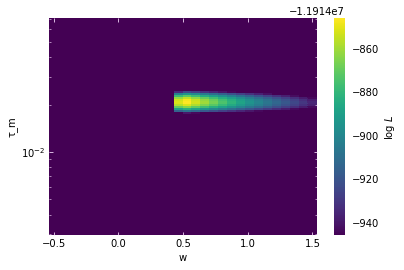

In [28]:
anlz.plot(logLT)

In [29]:
logLT.argmax()

(0.53448275862068972, 0.020742895543516271)

In [21]:
logL = heatmap.HeatMap.from_raw(io.loadraw("fsgif_4s_sin-input_loglikelihood_numpy_corrected.sir"))

In [22]:
logL.set_floor(logL.max()-100)

(<matplotlib.axes._subplots.AxesSubplot at 0x7f5464a9fba8>,
 <matplotlib.colorbar.Colorbar at 0x7f546118bdd8>)

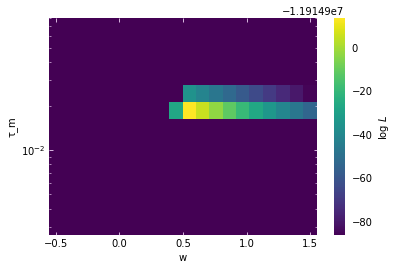

In [23]:
anlz.plot(logL)

In [24]:
logL.argmax()

(0.55263157894736836, 0.018841163261325577)